## Import

In [149]:
import torch
from torch.utils.data import DataLoader
import random
import shutil

import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
 
import scipy as scip
from scipy.special import softmax
from mpl_toolkits.axes_grid1 import make_axes_locatable
from copy import copy
from torch.nn import functional as F
from numpy.linalg import norm

from EWOthello.mingpt.probe_model import BatteryProbeClassification
from EWOthello.mingpt.utils import set_seed
from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * 
from EWOthello.mingpt.dataset import CharDataset 
import EWOthello.utils.plot_helpers as plt_utils
from EWOthello.mingpt.utils import  intervene

set_seed(44)
print(torch.cuda.is_available())
device = torch.cuda.current_device()
print(torch.cuda.get_device_name(device))

True
NVIDIA GeForce RTX 3090 Ti


In [37]:
# Get a the game dataset
othello = get(ood_num=-1, data_root=None, num_preload=1) # 11 corresponds to over 1 million games
game_dataset = CharDataset(othello) 
print("Data Loaded \n")

Max num files: 230; Use_num: 1
['gen10e5__20220324_165952.pickle']


Mem Used: 2.996 GB: 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]


Deduplicating...
Deduplicating finished with 99999 games left
Using 20 million for training, 0 for validation
Dataset created has 99999 sequences, 61 unique words.
Data Loaded 



## Define and test the causal-evaluation function

In [207]:
def convert_tbf_to_input(chunk, device, max_len=59):
    if len(chunk) != max_len:
        chunk += [-100] * (max_len - len(chunk))
    x_input = torch.tensor([game_dataset.stoi[tile] for tile in chunk], dtype=torch.long)
    return x_input[:-1].to(device)


def intervene_general(p, init_act, target_board, htd, rand_start=False):
    if rand_start:
        new_mid_act = torch.tensor(torch.rand(init_act.shape), dtype=torch.float32).to(device)
        new_mid_act.requires_grad = True
    else:
        new_mid_act = torch.tensor(init_act.clone().detach().cpu().numpy(), dtype=torch.float32).to(device)
        new_mid_act.requires_grad = True

    opt = torch.optim.Adam([new_mid_act], lr=htd["lr"])
    target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
    target_board.requires_grad = False
    for i in range(htd["steps"]):
        opt.zero_grad()
        logits_running = p(new_mid_act[None, :])[0][0]  # [64, 3]
        loss = F.cross_entropy(logits_running, target_board)
        loss = torch.mean(loss)
        loss.backward()  # by torch semantics, loss is to be minimized
        opt.step()

    return new_mid_act


def distance_CosSimLogits(pred_logits, gt_pred_logits):
    return np.dot(pred_logits, gt_pred_logits) / norm(pred_logits) / norm(gt_pred_logits)


def distance_KL_Prob(pred_logits, gt_pred_logits):
    pred_prob = softmax(pred_logits)
    gt_pred_prob = softmax(gt_pred_logits)

    # Check if the probability distributions sum up to 1 (with a small tolerance)
    assert np.abs(np.sum(pred_prob) - 1.0) < 1e-6, "The estimated probability distribution must sum up to 1."
    assert np.abs(np.sum(gt_pred_prob) - 1.0) < 1e-6, "The true probability distribution must sum up to 1."

    # Calculate the KL divergence
    kl_div = np.sum(pred_prob * np.log(pred_prob / gt_pred_prob))
    return kl_div


def causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves, verbose=False, reassertion=False):
    tbf = [game_dataset.itos[_] for _ in x.tolist()]
    ab = OthelloBoardState()
    ab.update(tbf[:number_played_moves], prt=False)
    init_board = np.array(ab.get_state()).reshape(8, 8)
    valid_moves = ab.get_valid_moves()
    idx_of_interest = number_played_moves
    padding = torch.zeros(2).cuda()  # Add in center two tiles with zero padding because output skips over them

    # Load the GPT Model for gameplay
    n_layer = int(probe_path[-5:-4])
    n_head = int(probe_path[-3:-2])
    gpt_othello_ckpt = probe_path + f"GPT_Synthetic_{n_layer}Layers_{n_head}Heads.ckpt"
    if verbose:
        print("Loading GPT Othello from checkpoint: ", gpt_othello_ckpt)
    mconf = GPTConfig(vocab_size=61, block_size=59, n_layer=n_layer, n_head=n_head, n_embd=512)
    model = GPTforProbeIA_ModV1(mconf)
    model.load_state_dict(torch.load(gpt_othello_ckpt))
    model.eval()
    model = model.to(device)

    # Load the set of probes
    probe_set = []
    for layer in range(1, n_layer + 1):
        probe = BatteryProbeClassification(device, probe_class=3, num_task=64, input_dim=512)
        probe_ckpt = probe_path + f"linearProbe_Map_New_{n_layer}L{n_head}H_GPT_Layer{layer}.ckpt"
        if verbose:
            print(f"Loading Pre-trained probe for layer: {layer}", probe_ckpt)
        probe.load_state_dict(torch.load(probe_ckpt))
        probe.eval()
        probe_set.append(probe)

    # Run the intervention sweep study
    if verbose:
        print("Run Intervention")
    htd = {"lr": 5e-2, "steps": 3000}
    if len(valid_moves) > 1:
        tbf_input = copy(tbf)[:number_played_moves]
        tbf_input.append(valid_moves[0])
        x_input = convert_tbf_to_input(tbf_input, device)
        ab_input = OthelloBoardState()
        ab_input.update(tbf_input[: number_played_moves + 1], prt=False)
        input_board = np.array(ab_input.get_state())

        hold_distance_cos = []
        hold_distance_kl = []
        hold_ref_cos = []
        hold_ref_kl = []
        for alt_move in valid_moves[1:]:
            # Compute the logits for the alternative boards passed in
            tbf_gt = copy(tbf)[:number_played_moves]
            tbf_gt.append(alt_move)
            x_gt = convert_tbf_to_input(tbf_gt, device)

            act_gt = model.forward_1st_stage(probe_layer, x_gt[None, :])[0]
            gt_board_logits, _ = probe_set[probe_layer - 1](act_gt[idx_of_interest, :])
            gt_board = torch.argmax(gt_board_logits, -1, keepdim=False).detach().cpu()
            pred_gt, _ = model.predict(model.forward_2nd_stage(act_gt[None], probe_layer, -1)[0][0])
            pred_gt = pred_gt[idx_of_interest, 1:]
            pred_gt = torch.cat([pred_gt[:27], padding, pred_gt[27:33], padding, pred_gt[33:]], dim=0).detach().cpu().numpy()

            # Compute the logits for the board placed in by intervention
            intv_activation = model.forward_1st_stage(probe_layer, x_input[None, :])[0]
            new_activation = intervene_general(probe_set[probe_layer - 1], intv_activation[idx_of_interest, :], gt_board[0], htd)
            intv_activation[number_played_moves, :] = new_activation
            reconst_board, _ = probe_set[probe_layer - 1](intv_activation[idx_of_interest, :])
            reconst_board = torch.argmax(reconst_board, -1, keepdim=False).detach().cpu().reshape(8, 8)
            if reassertion:
                for layer in range(probe_layer, 8):
                    intv_activation = model.forward_2nd_stage(intv_activation[None], layer, layer + 1)[0][0]
                    new_activation = intervene_general(probe_set[layer], intv_activation[idx_of_interest, :], gt_board[0], htd)
                    intv_activation[idx_of_interest, :] = new_activation
            else:
                intv_activation = model.forward_2nd_stage(intv_activation[None], probe_layer, -1)[0][0]

            post_intv_pred, _ = model.predict(intv_activation)
            post_intv_pred = post_intv_pred[idx_of_interest, 1:]
            post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
            post_intv_pred = post_intv_pred.detach().cpu().numpy()

            # Lets also compute the logits for no intervention
            no_intv_pred, _ = model.predict(model.forward_1st_stage(-1, x_input[None, :])[0])
            no_intv_pred = no_intv_pred[idx_of_interest, 1:]
            no_intv_pred = torch.cat([no_intv_pred[:27], padding, no_intv_pred[27:33], padding, no_intv_pred[33:]], dim=0)
            no_intv_pred = no_intv_pred.detach().cpu().numpy()

            # Compute distance metrics
            ref_distance_cos = distance_CosSimLogits(no_intv_pred, pred_gt)
            distance_cos = distance_CosSimLogits(post_intv_pred, pred_gt)
            ref_distance_kl = distance_KL_Prob(no_intv_pred, pred_gt)
            distance_kl = distance_KL_Prob(post_intv_pred, pred_gt)

            hold_distance_cos.append(distance_cos)
            hold_distance_kl.append(distance_kl)
            hold_ref_cos.append(ref_distance_cos)
            hold_ref_kl.append(ref_distance_kl)

            if verbose:
                fig = plt.figure(figsize=(12, 8))
                ax = plt_utils.addAxis(fig, 2, 3)
                plt_utils.plot_game_discs(init_board, ax[0])
                ax[0].set_title("Unplayed Board")
                plt_utils.plot_game_discs(gt_board.reshape(8, 8), ax[1])
                ax[1].set_title("Played Move")

                ax[2].imshow(pred_gt.reshape(8, 8))
                ax[2].set_title("Played Next-Move Logits")

                plt_utils.plot_game_discs(input_board.reshape(8, 8), ax[3])
                ax[3].set_title("Alternative Move")

                ax[4].imshow(no_intv_pred.reshape(8, 8))
                ax[4].set_title(f"No Intv Logits; Sim: {ref_distance_cos:.2f}")
                ax[5].imshow(post_intv_pred.reshape(8, 8))
                ax[5].set_title(f"Post Intv Logits; Sim: {distance_cos:.2f}")
                plt_utils.format_ax_boardImage(ax)

        return (
            np.mean(hold_distance_cos),
            np.mean(hold_ref_cos),
            np.mean(hold_distance_kl),
            np.mean(hold_ref_kl),
        )
    else:
        return None, None, None, None


Loading GPT Othello from checkpoint:  ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/GPT_Synthetic_8Layers_8Heads.ckpt
Loading Pre-trained probe for layer: 1 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer1.ckpt
Loading Pre-trained probe for layer: 2 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer2.ckpt
Loading Pre-trained probe for layer: 3 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer3.ckpt
Loading Pre-trained probe for layer: 4 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer4.ckpt
Loading Pre-trained probe for layer: 5 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer5.ckpt
Loading Pre-trained probe for layer: 6 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer6.ckpt
Loading Pre-trained probe for layer: 7 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/linearProbe_Map_New_8L8H_GPT_Layer7.ckpt
Loading 

/tmp/ipykernel_998098/1816067997.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)


(0.9535562, 0.5263365, 0.5700088, 2.977039)

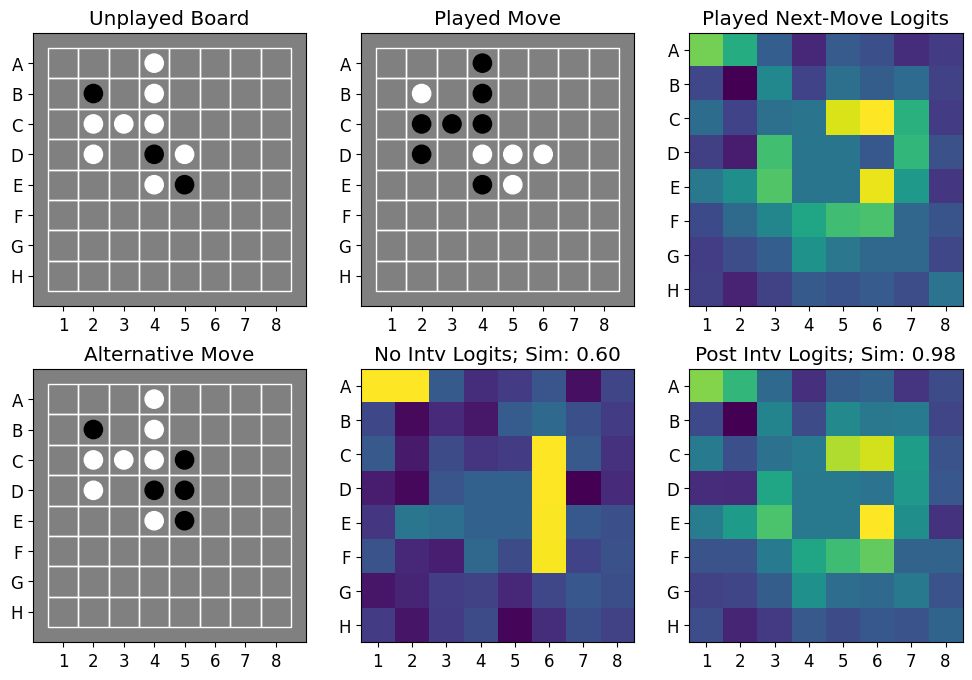

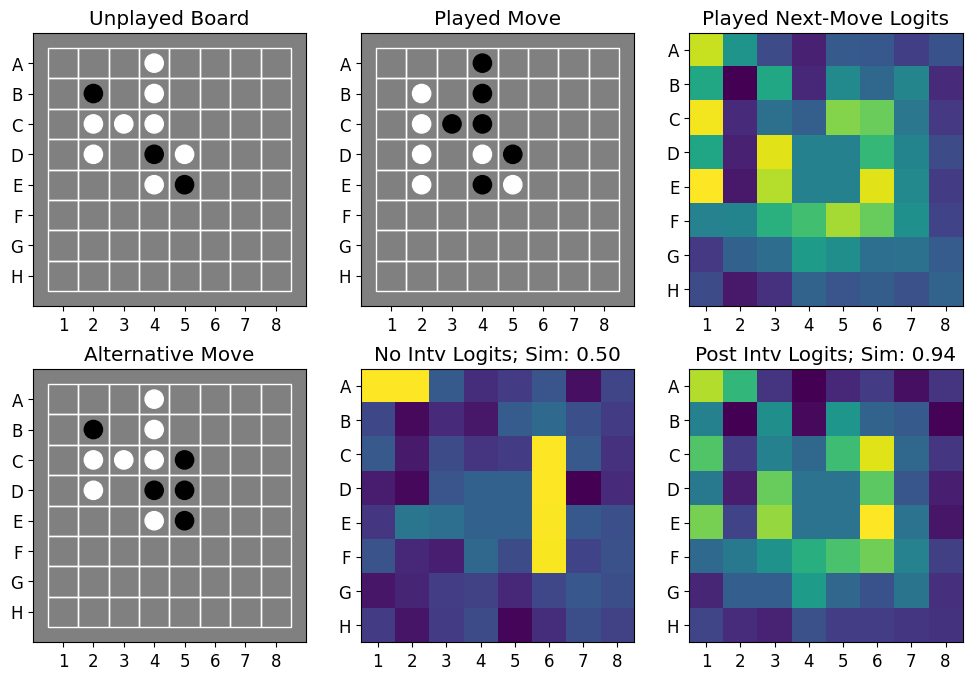

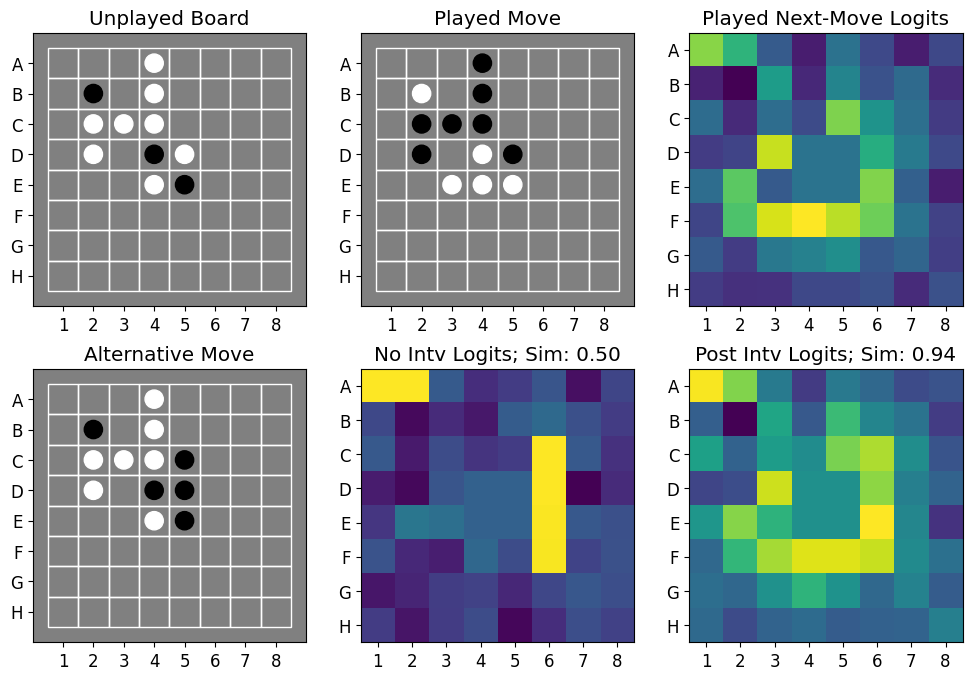

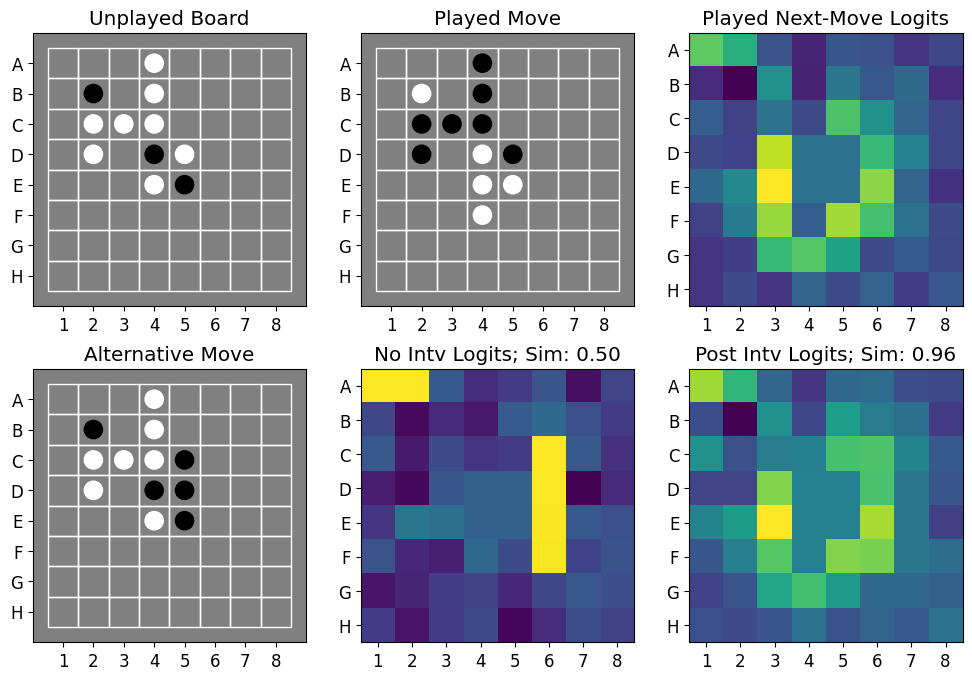

In [208]:
index = 375
x, _ = game_dataset[index]
probe_layer = 4
played_moves = 7
probe_path = "../EWOthello/ckpts/Dean_GPTv2_Synthetic_8L8H/"
causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves=played_moves, verbose=True)

Loading GPT Othello from checkpoint:  ../EWOthello/ckpts/Dean_GPTv2_Synthetic_4L8H/GPT_Synthetic_4Layers_8Heads.ckpt
Loading Pre-trained probe for layer: 1 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_4L8H/linearProbe_Map_New_4L8H_GPT_Layer1.ckpt
Loading Pre-trained probe for layer: 2 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_4L8H/linearProbe_Map_New_4L8H_GPT_Layer2.ckpt
Loading Pre-trained probe for layer: 3 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_4L8H/linearProbe_Map_New_4L8H_GPT_Layer3.ckpt
Loading Pre-trained probe for layer: 4 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_4L8H/linearProbe_Map_New_4L8H_GPT_Layer4.ckpt
Run Intervention


/tmp/ipykernel_998098/1816067997.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)


(0.7692864, 0.63886285, 1.9178649, 3.4269903)

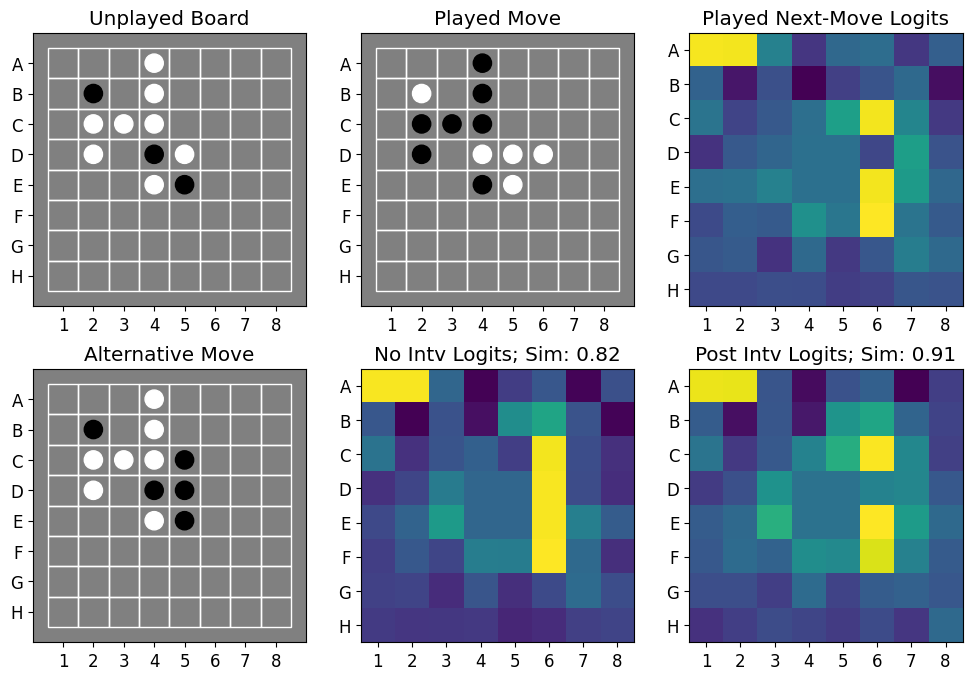

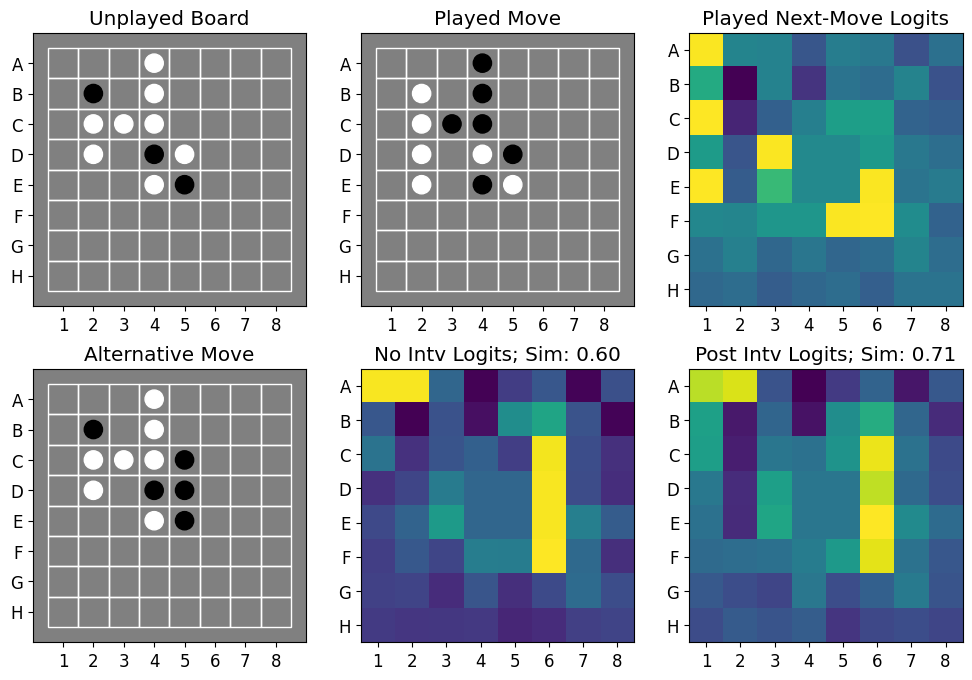

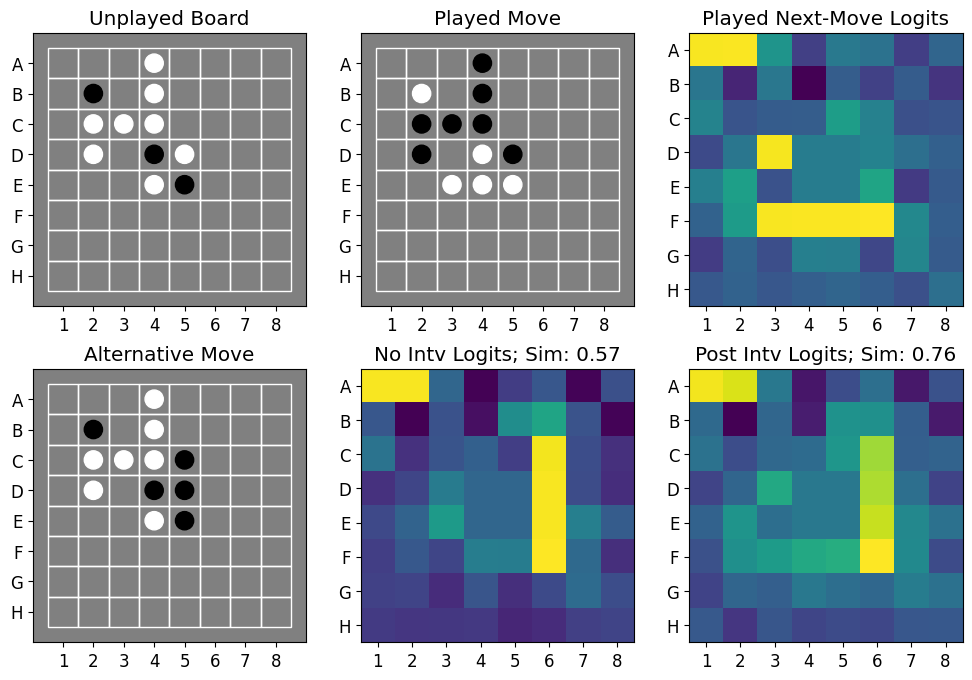

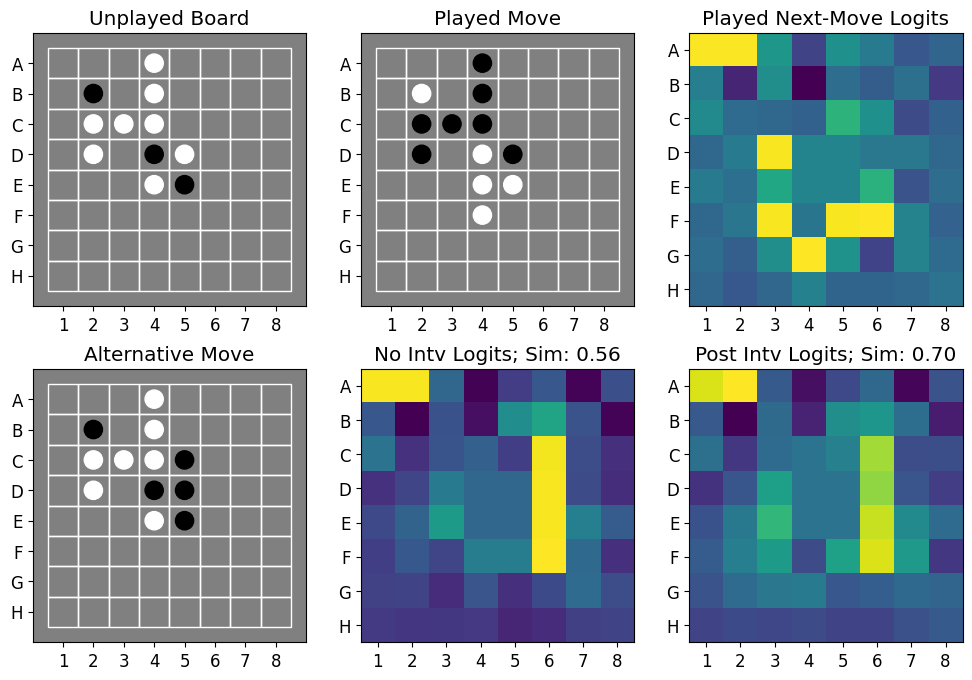

In [209]:
index = 375
x, _ = game_dataset[index]
probe_layer = 4
played_moves = 7
probe_path = "../EWOthello/ckpts/Dean_GPTv2_Synthetic_4L8H/"
causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves=played_moves, verbose=True)

Loading GPT Othello from checkpoint:  ../EWOthello/ckpts/Dean_GPTv2_Synthetic_1L8H/GPT_Synthetic_1Layers_8Heads.ckpt
Loading Pre-trained probe for layer: 1 ../EWOthello/ckpts/Dean_GPTv2_Synthetic_1L8H/linearProbe_Map_New_1L8H_GPT_Layer1.ckpt
Run Intervention


/tmp/ipykernel_998098/1816067997.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)


(0.8464526, 0.70282483, 1.6160183, 2.1865401)

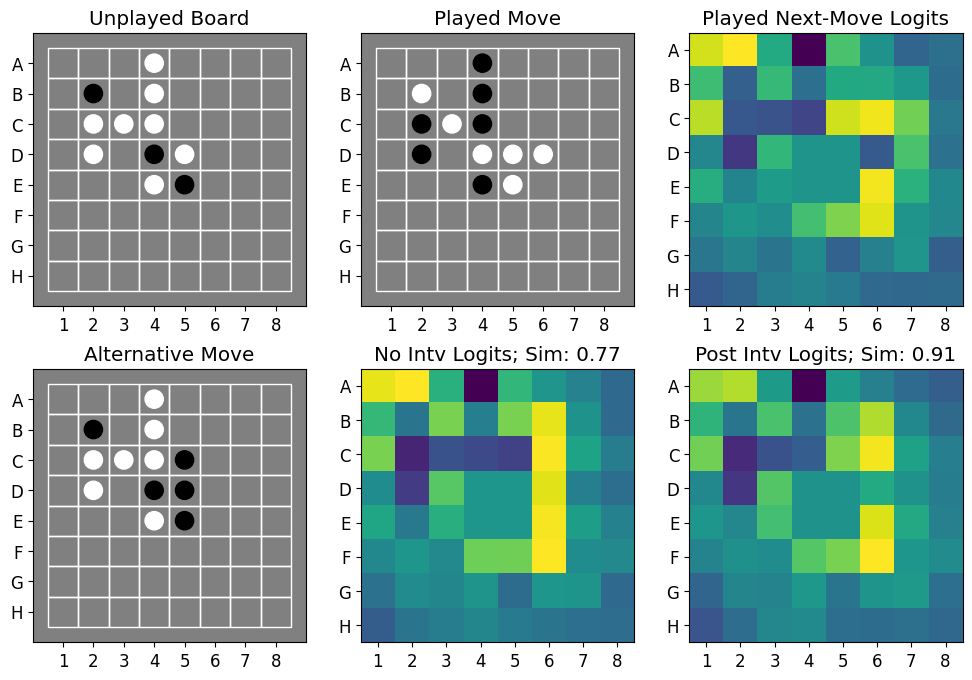

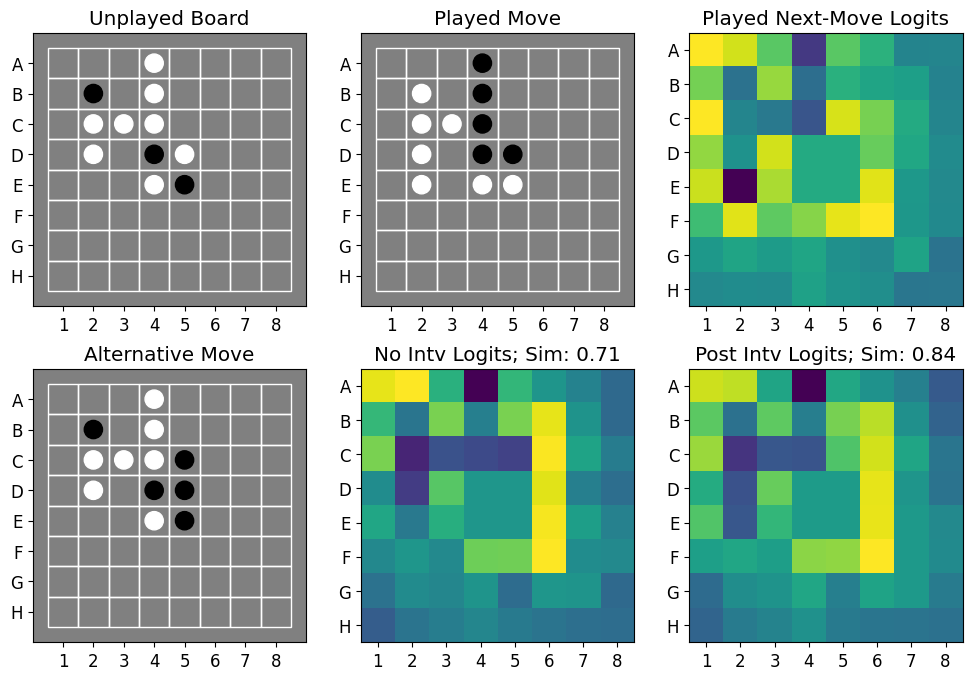

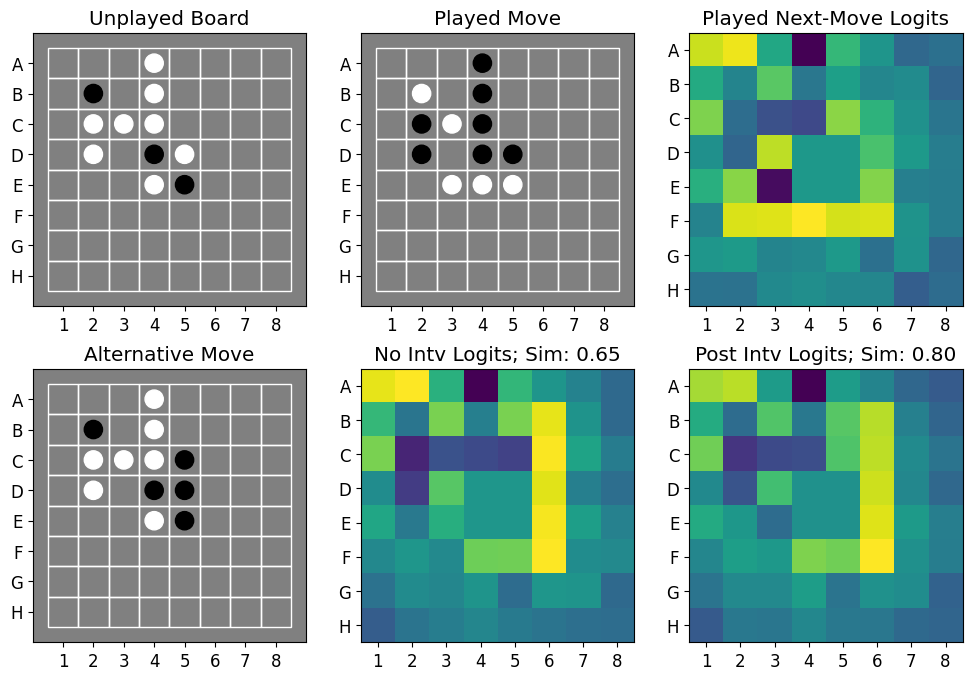

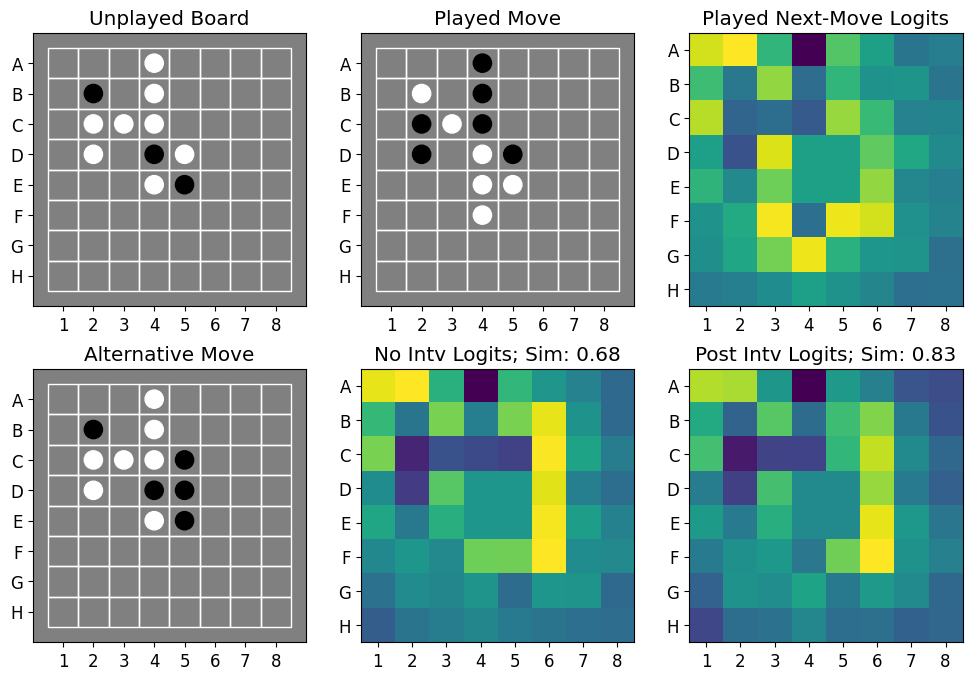

In [210]:
index = 375
x, _ = game_dataset[index]
probe_layer = 1
played_moves = 7
probe_path = "../EWOthello/ckpts/Dean_GPTv2_Synthetic_1L8H/"
causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves=played_moves, verbose=True)

## Run Causal-Evaluation Game Sweep

In [211]:
def sweep_causal_interv_evaluation(game_dataset, num_games, probe_path, seed):
    random.seed(a=seed)
    if not os.path.exists("saved_data"):
        os.mkdir("saved_data")
    
    # Control the sweep ranges and step for testing vs final result runs since it takes time
    max_seq_len=58
    seq_step=5
    probe_step=1
    n_layer = int(probe_path[-5:-4])

    # Loop over different game sequences to get an averaged result
    intv_data = []
    ref_data = []
    for idx in tqdm(random.sample(list(range(len(game_dataset))), num_games)):
        x, _= game_dataset[idx]
        # Loop over probe Layer
        hold_probe_sim = []
        hold_ref_sim = []
        for probe_layer in np.arange(1, n_layer+1, probe_step):
            # Loop over number of moves played length
            distances_vs_gamelength = []
            ref_vs_gamelength = []
            for number_played_moves in np.arange(0, max_seq_len, seq_step):
                cos_dis, cos_ref, kl_dis, kl_ref = causal_intervention_logit_evaluation(x, probe_path, probe_layer, number_played_moves, verbose=False)
                distances_vs_gamelength.append([cos_dis, kl_dis])
                ref_vs_gamelength.append([cos_ref, kl_ref])

            hold_probe_sim.append(distances_vs_gamelength)
            hold_ref_sim.append(ref_vs_gamelength)

        intv_data.append(np.array(hold_probe_sim))
        ref_data.append(np.array(hold_ref_sim))

        # save benchmark since this may take a while
        save_tag = probe_path.split("/")[-2]
        save_fold = f"saved_data/{save_tag}_DataSave_idx{idx}.pickle"
        with open(save_fold, 'wb') as fhandle:
            pickle.dump({"sim_data": intv_data, "ref_data":ref_data}, fhandle)

    return intv_data, ref_data 

In [228]:
# Sweep the probe analysis for all trained GPT Models and Linear Probes
datapath = "../EWOthello/ckpts/"
all_files = os.listdir(datapath)
GPT_Folders = [name for name in all_files if name.startswith("Dean_GPTv2_Synthetic")]
GPT_Folders.sort()
print(GPT_Folders)
use_seed=random.randint(0, int(1e6))
number_games_use=5
for fold in GPT_Folders:
    intv_data, ref_data = sweep_causal_interv_evaluation(game_dataset, number_games_use, "../EWOthello/ckpts/"+fold+"/", use_seed)


['Dean_GPTv2_Synthetic_1L1H', 'Dean_GPTv2_Synthetic_1L8H', 'Dean_GPTv2_Synthetic_4L1H', 'Dean_GPTv2_Synthetic_4L8H', 'Dean_GPTv2_Synthetic_8L8H']


  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_998098/1816067997.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_board = torch.tensor(target_board.clone(), dtype=torch.int64).to(device)
100%|██████████| 5/5 [1:29:28<00:00, 1073.65s/it]


/tmp/ipykernel_998098/2943644049.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


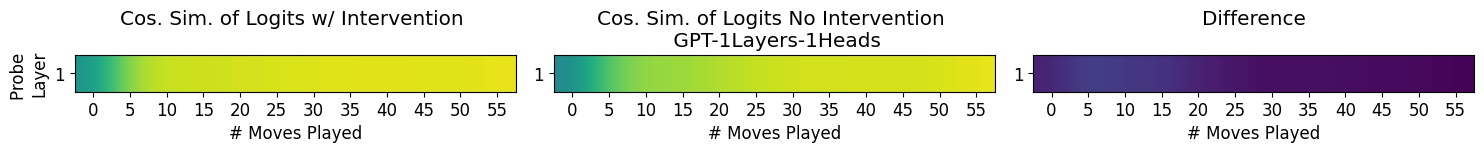

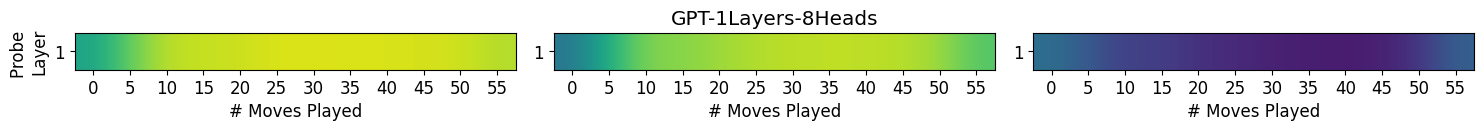

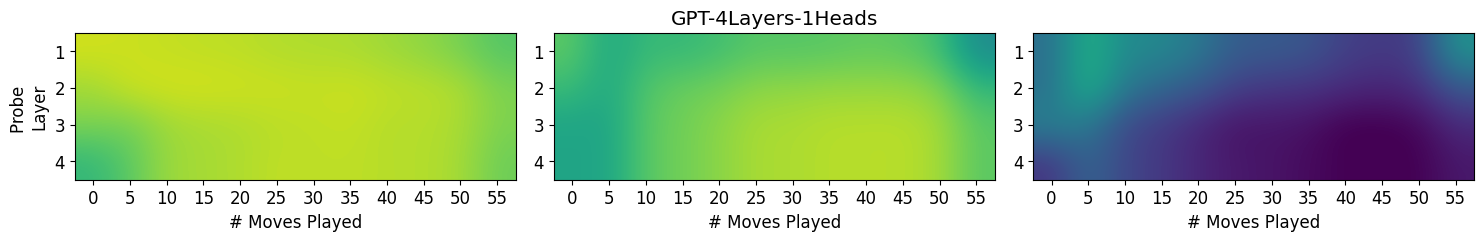

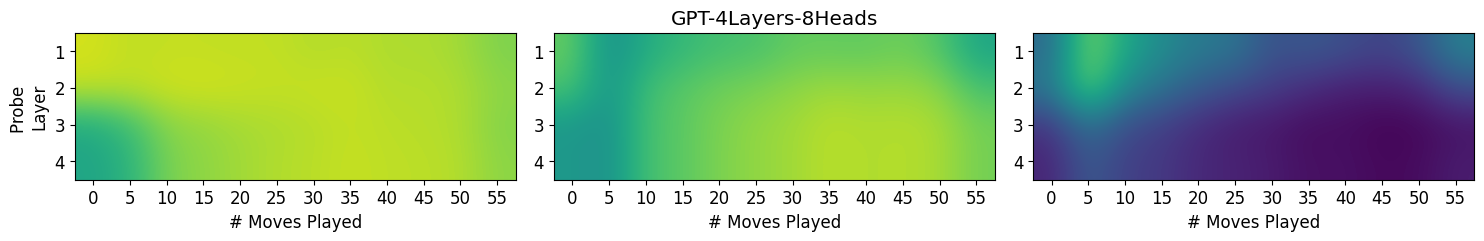

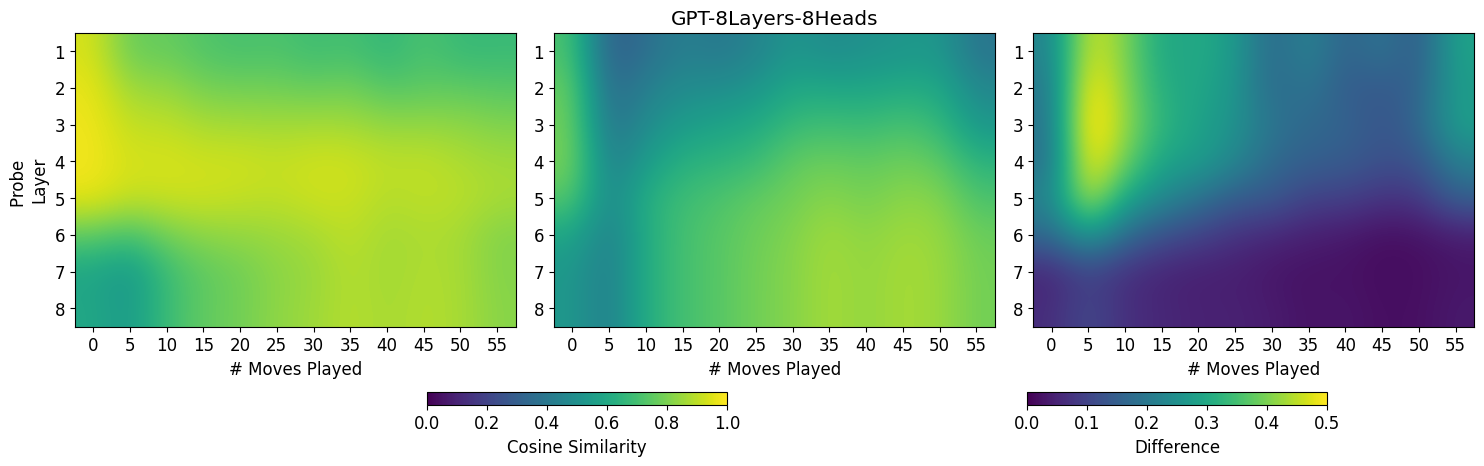

In [231]:
## Plot the data with cosine similarity as the logit distance metric
plt.rcParams.update({'font.size': 12})
all_dat_files = os.listdir("saved_data/")
counter = -1
for fold in GPT_Folders:
    counter+=1
    n_layer = int(fold[-4:-3])
    n_head = int(fold[-2:-1])
    ylabels = np.arange(1, 1+n_layer, 1)
    xvec = np.arange(0, 58, 5)
    
    list_files = [f for f in all_dat_files if fold in f and f.endswith(".pickle")]
    intv_data = []
    ref_data = []
    for dat_file in list_files:        
        with open("saved_data/"+dat_file, 'rb') as fhandle:
            data = pickle.load(fhandle)
            intv_data.append(np.array(data["sim_data"]))
            ref_data.append(np.array(data["ref_data"]))

    intv_data = np.nanmean(np.concatenate(intv_data,axis=0).astype(float), axis=0)
    ref_data = np.nanmean(np.concatenate(ref_data, axis=0).astype(float), axis=0)
    
    # Make Plot
    fig = plt.figure(figsize=(15,5))
    ax = plt_utils.addAxis(fig,1,3)
    ax[0].imshow(intv_data[:,:,0], vmin=0, vmax=1, interpolation="bicubic", aspect="equal")
    ax[1].imshow(ref_data[:,:,0], vmin=0, vmax=1, interpolation="bicubic", aspect="equal")
    ax[2].imshow(intv_data[:,:,0] - ref_data[:,:,0], vmin=0, vmax=0.5, interpolation="bicubic", aspect="equal")

    # Format the axis
    for thisax in ax:
        thisax.set_yticks(range(n_layer))
        thisax.set_yticklabels(ylabels)     
        thisax.set_xticks(range(len(xvec)))
        thisax.set_xticklabels(xvec)
        thisax.set_xlabel("# Moves Played")
    ax[0].set_ylabel("Probe \nLayer")
    ax[1].set_title(f"GPT-{n_layer}Layers-{n_head}Heads")
    
    if counter==0:
        ax[0].set_title("Cos. Sim. of Logits w/ Intervention \n")
        ax[1].set_title(f"Cos. Sim. of Logits No Intervention \n GPT-{n_layer}Layers-{n_head}Heads")
        ax[2].set_title("Difference\n")
    if counter==len(GPT_Folders)-1:
        cax = fig.add_axes([0.29, 0.05, 0.2, 0.025])
        cb = fig.colorbar(ax[0].images[0], cax=cax, orientation="horizontal")
        cb.set_label("Cosine Similarity")
        cax = fig.add_axes([0.69, 0.05, 0.20, 0.025])
        cb = fig.colorbar(ax[2].images[0], cax=cax, orientation="horizontal")
        cb.set_label("Difference")
    plt.tight_layout()
    plt.savefig("saved_data/"+fold+".png", bbox_inches='tight', pad_inches=0.1)


In [187]:
# ## Plot the data with KL Divergence as the logit-probability distance metric
# plt.rcParams.update({'font.size': 12})
# all_dat_files = os.listdir("saved_data/")
# counter = -1
# for fold in GPT_Folders:
#     counter+=1
#     n_layer = int(fold[-4:-3])
#     n_head = int(fold[-2:-1])
#     ylabels = np.arange(1, 1+n_layer, 1)
#     xvec = np.arange(0, 58, 5)
    
#     list_files = [f for f in all_dat_files if fold in f]
#     for dat_file in list_files:
#         intv_data = []
#         ref_data = []
#         with open("saved_data/"+dat_file, 'rb') as fhandle:
#             data = pickle.load(fhandle)
#             intv_data.append(np.array(data["sim_data"]))
#             ref_data.append(np.array(data["ref_data"]))
#         intv_data = np.mean(np.concatenate(intv_data,axis=0), axis=0)
#         ref_data = np.mean(np.concatenate(ref_data, axis=0), axis=0)
        
#         # Make Plot
#         fig = plt.figure(figsize=(15,5))
#         ax = plt_utils.addAxis(fig,1,3)
#         ax[0].imshow(intv_data[:,:,1], vmin=0, vmax=7, interpolation="bicubic", aspect="equal")
#         ax[1].imshow(ref_data[:,:,1], vmin=0, vmax=7, interpolation="bicubic", aspect="equal")
#         ax[2].imshow(intv_data[:,:,1] - ref_data[:,:,0], vmin=0, vmax=7, interpolation="bicubic", aspect="equal")

#         # Format the axis
#         for thisax in ax:
#             thisax.set_yticks(range(n_layer))
#             thisax.set_yticklabels(ylabels)     
#             thisax.set_xticks(range(len(xvec)))
#             thisax.set_xticklabels(xvec)
#             thisax.set_xlabel("# Moves Played")
#         ax[0].set_ylabel("Probe \nLayer")
#         ax[1].set_title(f"GPT-{n_layer}Layers-{n_head}Heads")
        
#         if counter==0:
#             ax[0].set_title("Distance of Logits w/ Intervention \n")
#             ax[1].set_title(f"Distance Logits No Intervention \n GPT-{n_layer}Layers-{n_head}Heads")
#             ax[2].set_title("Difference\n")
#         if counter==len(GPT_Folders)-1:
#             cax = fig.add_axes([0.29, 0.1, 0.2, 0.025])
#             cb = fig.colorbar(ax[0].images[0], cax=cax, orientation="horizontal")
#             cb.set_label("KL Divergence (probability)")

#             cax = fig.add_axes([0.69, 0.1, 0.20, 0.025])
#             cb = fig.colorbar(ax[2].images[0], cax=cax, orientation="horizontal")
#             cb.set_label("Difference")
